гнилой пиздеж про то откуда данные как они выглядят в черновом варианте и что мы сделаем с ними в этой тетрадке

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np

достаем данные (надо будет их залить в облако)

In [2]:
conn = sqlite3.connect('database.sqlite') # https://disk.yandex.ru/d/SzXXSHnMUBK2DQ
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

for table in tables:
    print(table[0])

sqlite_sequence
Player_Attributes
Player
Match
League
Country
Team
Team_Attributes


разбираемся с таблицей match

In [13]:
match = pd.read_sql('SELECT * FROM Match', conn)
match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


очень жесткий пиздежь про почти каждый столбец с описанием (очев группируя некоторые) говорим сразу, что тему с кэфами выкидываем остальное щас будем анализировать

In [14]:
match.shape

(25979, 115)

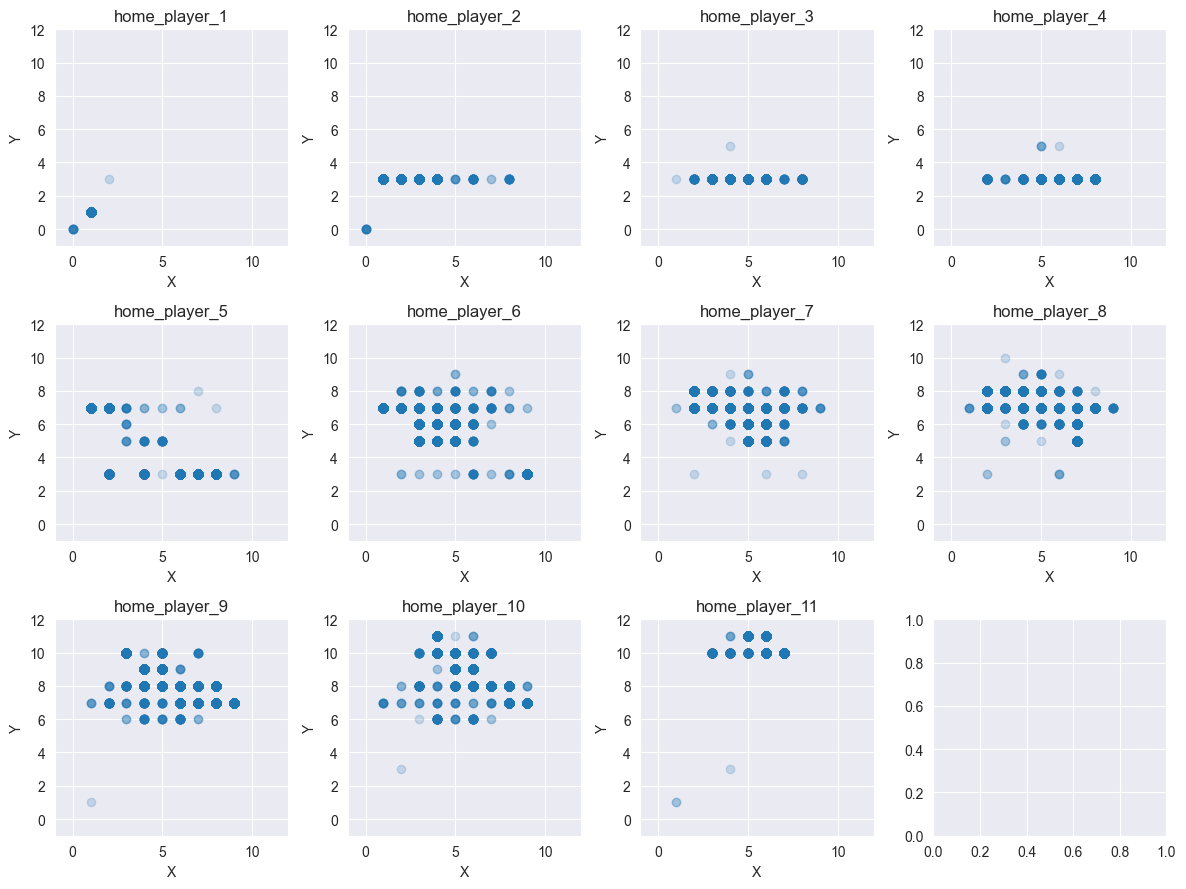

In [15]:
fig, axs = plt.subplots(3, 4, figsize=(12, 9))
axs = axs.flatten()

for i in range(1, 12):
    ax = axs[i - 1]
    ax.scatter(match[f'home_player_X{i}'], match[f'home_player_Y{i}'], alpha=0.2)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'home_player_{i}')
    ax.set_xlim(-1, 12)
    ax.set_ylim(-1, 12)

plt.tight_layout()
plt.show()

тут вот если ты че то придумаешь в плане анализа будет норм, очев первый игрок это воротчик (аххахаха как я наивен, дальше выяснется что это не так), мб можно проверятьк акие то гипотезы на счет того кто какой ногой играет или связь роста и близость к воротам противника, хз как это нам поможет но что то высрать надо

In [16]:
len(match[(match['home_player_X1'] > 1) & (match['home_player_Y1'] > 1)])

1

In [17]:
for i in range(1, 12):
    print(len(match[(match[f'home_player_X{i}'] <= 1) & (match[f'home_player_Y{i}'] <= 1)]))

24157
11
0
0
0
0
0
0
1
0
2


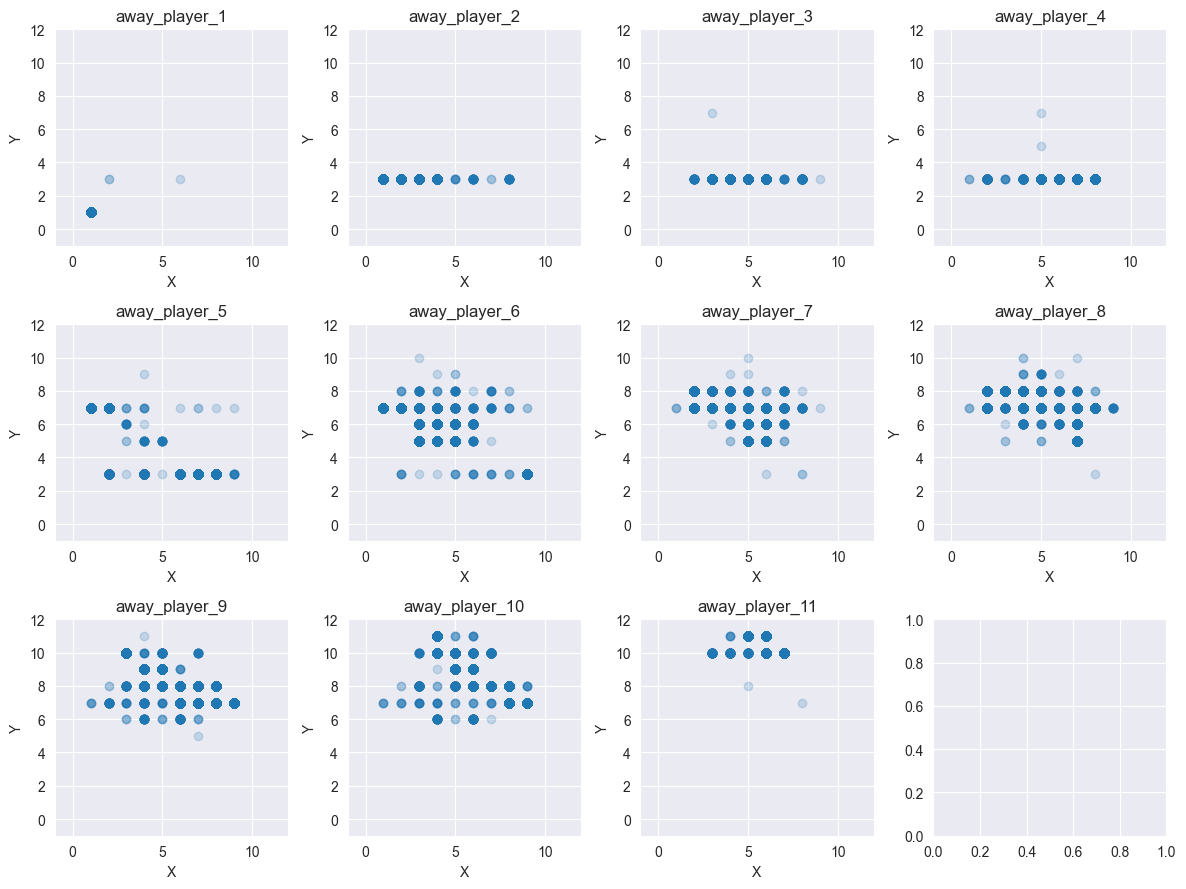

In [18]:
fig, axs = plt.subplots(3, 4, figsize=(12, 9))
axs = axs.flatten()

for i in range(1, 12):
    ax = axs[i - 1]
    ax.scatter(match[f'away_player_X{i}'], match[f'away_player_Y{i}'], alpha=0.2)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'away_player_{i}')
    ax.set_xlim(-1, 12)
    ax.set_ylim(-1, 12)

plt.tight_layout()
plt.show()

делаем вывод, что те футболисты координаты которых меньше 1, являются вратарями, посему, сделаем сет вратерей и полевых:

In [19]:
goalkeepers = []
for i in range(1, 12):
    home_goalkeepers = np.array(match.loc[(match[f'home_player_Y{i}'] <= 1)][
                                    f'home_player_{i}'])
    away_goalkeepers = np.array(match.loc[(match[f'away_player_Y{i}'] <= 1)][
                                    f'away_player_{i}'])
    goalkeepers = np.unique(np.append(np.append(home_goalkeepers, away_goalkeepers), goalkeepers))

In [20]:
fielders = []
for i in range(1, 12):
    home_fielders = np.array(match.loc[(match[f'home_player_Y{i}'] > 1)][
                                 f'home_player_{i}'])
    away_fielders = np.array(match.loc[(match[f'away_player_Y{i}'] > 1)][
                                 f'away_player_{i}'])
    fielders = np.unique(np.append(np.append(home_fielders, away_fielders), fielders))

ну и удалим пока их нахуй, если пригодятся то вернемся + привожу дату в номр вид

In [21]:
for i in range(1, 12):
    match.drop(columns=[f'home_player_X{i}', f'home_player_Y{i}'], inplace=True)
    match.drop(columns=[f'away_player_X{i}', f'away_player_Y{i}'], inplace=True)
match['date'] = pd.to_datetime(match['date'])

теперь разберемся с колонками про кэфы (все таки мысль сделать таргетом именно их меня не покидает, в целом мы таким образом превратим классификацию в регресиию, и как будто тут чуть чуть побольше пространства для фантазии, но скора хорошего для картинки будет добится сложновато)

In [22]:
columns_bookers = ['B365H',
                   'B365D',
                   'B365A',
                   'BWH',
                   'BWD',
                   'BWA',
                   'IWH',
                   'IWD',
                   'IWA',
                   'LBH',
                   'LBD',
                   'LBA',
                   'PSH',
                   'PSD',
                   'PSD',
                   'PSA',
                   'WHH',
                   'WHD',
                   'WHA',
                   'SJH',
                   'SJD',
                   'SJA',
                   'VCH',
                   'VCD',
                   'VCA',
                   'GBH',
                   'GBD',
                   'GBA',
                   'BSH',
                   'BSD',
                   'BSA']
match.drop(columns=columns_bookers, inplace=True)

удалим логи матча

In [23]:
columns_with_logs = ['goal',
                     'shoton',
                     'shotoff',
                     'foulcommit',
                     'card',
                     'cross',
                     'corner',
                     'possession']
match.drop(columns=columns_with_logs, inplace=True)

In [24]:
match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11
0,1,1,1,2008/2009,1,2008-08-17,492473,9987,9993,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,1,2008/2009,1,2008-08-16,492474,10000,9994,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,1,2008/2009,1,2008-08-16,492475,9984,8635,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,1,2008/2009,1,2008-08-17,492476,9991,9998,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,1,2008/2009,1,2008-08-16,492477,7947,9985,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
match.isna().sum()

id                     0
country_id             0
league_id              0
season                 0
stage                  0
date                   0
match_api_id           0
home_team_api_id       0
away_team_api_id       0
home_team_goal         0
away_team_goal         0
home_player_1       1224
home_player_2       1315
home_player_3       1281
home_player_4       1323
home_player_5       1316
home_player_6       1325
home_player_7       1227
home_player_8       1309
home_player_9       1273
home_player_10      1436
home_player_11      1555
away_player_1       1234
away_player_2       1278
away_player_3       1293
away_player_4       1321
away_player_5       1335
away_player_6       1313
away_player_7       1235
away_player_8       1341
away_player_9       1328
away_player_10      1441
away_player_11      1554
dtype: int64

удалим сразу все матчи в которых нам неизмевстны игроки

In [26]:
for i in range(1, 12):
    match.dropna(subset=[f'home_player_{i}', f'away_player_{i}'], inplace=True)
match['date'] = pd.to_datetime(match['date'])

In [27]:
match.isna().sum().sum()

0

больше пропущенных даненых нет пока оставим так пощзже вернемся

In [28]:
match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11
145,146,1,1,2008/2009,24,2009-02-27,493017,8203,9987,2,...,38293.0,148313.0,104411.0,148314.0,37202.0,43158.0,9307.0,42153.0,32690.0,38782.0
153,154,1,1,2008/2009,25,2009-03-08,493025,9984,8342,1,...,21812.0,11736.0,37858.0,38366.0,37983.0,39578.0,38336.0,52280.0,27423.0,38440.0
155,156,1,1,2008/2009,25,2009-03-07,493027,8635,10000,2,...,37886.0,37903.0,37889.0,94030.0,37893.0,37981.0,131531.0,130027.0,38231.0,131530.0
162,163,1,1,2008/2009,26,2009-03-13,493034,8203,8635,2,...,38388.0,38389.0,31316.0,164694.0,30949.0,38378.0,38383.0,38393.0,38253.0,37069.0
168,169,1,1,2008/2009,26,2009-03-14,493040,10000,9999,0,...,38247.0,16387.0,94288.0,94284.0,45832.0,26669.0,33671.0,163670.0,37945.0,33622.0


чекнем лиги

In [29]:
league = pd.read_sql('SELECT * FROM League', conn)
league

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


заменим индекс лиги на ее название хули нам

In [30]:
league.rename(columns={'id': 'league_id', 'name': 'league_name'}, inplace=True)
match = pd.merge(match, league, on='league_id', how='right')

match.drop(['league_id', 'country_id_y', 'country_id_x'], axis=1, inplace=True)

In [31]:
match.head()

,id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_1,...,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,league_name
0,146,2008/2009,24,2009-02-27,493017,8203,9987,2,1,38327.0,...,148313.0,104411.0,148314.0,37202.0,43158.0,9307.0,42153.0,32690.0,38782.0,Belgium Jupiler League
1,154,2008/2009,25,2009-03-08,493025,9984,8342,1,3,36835.0,...,11736.0,37858.0,38366.0,37983.0,39578.0,38336.0,52280.0,27423.0,38440.0,Belgium Jupiler League
2,156,2008/2009,25,2009-03-07,493027,8635,10000,2,0,34480.0,...,37903.0,37889.0,94030.0,37893.0,37981.0,131531.0,130027.0,38231.0,131530.0,Belgium Jupiler League
3,163,2008/2009,26,2009-03-13,493034,8203,8635,2,1,38327.0,...,38389.0,31316.0,164694.0,30949.0,38378.0,38383.0,38393.0,38253.0,37069.0,Belgium Jupiler League
4,169,2008/2009,26,2009-03-14,493040,10000,9999,0,0,37900.0,...,16387.0,94288.0,94284.0,45832.0,26669.0,33671.0,163670.0,37945.0,33622.0,Belgium Jupiler League


теперь названия команд

In [32]:
team = pd.read_sql('SELECT * FROM Team', conn)
team.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [33]:
team.rename(columns={'team_long_name': 'team_name'}, inplace=True)
team.drop(['team_fifa_api_id', 'id', 'team_short_name'], axis=1, inplace=True)

In [34]:
match = pd.merge(match, team, left_on='home_team_api_id', right_on='team_api_id', how='left')

In [35]:
match = pd.merge(match, team, left_on='away_team_api_id', right_on='team_api_id', how='left')

In [36]:
match.drop(['away_team_api_id', 'id', 'home_team_api_id', 'team_api_id_x', 'team_api_id_y'], axis=1, inplace=True)
match.rename(columns={'team_name_x': 'home_team_name', 'team_name_y': 'away_team_name', }, inplace=True)

In [37]:
match.insert(0, 'home_team_name', match.pop('home_team_name'))
match.insert(0, 'away_team_name', match.pop('away_team_name'))
match.insert(0, 'league_name', match.pop('league_name'))

In [38]:
match.head()

,league_name,away_team_name,home_team_name,season,stage,date,match_api_id,home_team_goal,away_team_goal,home_player_1,...,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11
0,Belgium Jupiler League,KRC Genk,KV Mechelen,2008/2009,24,2009-02-27,493017,2,1,38327.0,...,38293.0,148313.0,104411.0,148314.0,37202.0,43158.0,9307.0,42153.0,32690.0,38782.0
1,Belgium Jupiler League,Club Brugge KV,KSV Cercle Brugge,2008/2009,25,2009-03-08,493025,1,3,36835.0,...,21812.0,11736.0,37858.0,38366.0,37983.0,39578.0,38336.0,52280.0,27423.0,38440.0
2,Belgium Jupiler League,SV Zulte-Waregem,RSC Anderlecht,2008/2009,25,2009-03-07,493027,2,0,34480.0,...,37886.0,37903.0,37889.0,94030.0,37893.0,37981.0,131531.0,130027.0,38231.0,131530.0
3,Belgium Jupiler League,RSC Anderlecht,KV Mechelen,2008/2009,26,2009-03-13,493034,2,1,38327.0,...,38388.0,38389.0,31316.0,164694.0,30949.0,38378.0,38383.0,38393.0,38253.0,37069.0
4,Belgium Jupiler League,KSV Roeselare,SV Zulte-Waregem,2008/2009,26,2009-03-14,493040,0,0,37900.0,...,38247.0,16387.0,94288.0,94284.0,45832.0,26669.0,33671.0,163670.0,37945.0,33622.0


че там с тим_атрибутс, спойлер там пиздец

In [39]:
team_attributes = pd.read_sql('SELECT * FROM Team_Attributes', conn)
team_attributes.head()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,4,77,8485,2010-02-22 00:00:00,70,Fast,NaN,Little,70,Long,...,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,5,77,8485,2011-02-22 00:00:00,47,Balanced,NaN,Little,52,Mixed,...,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover


In [40]:
team_attributes['date'] = pd.to_datetime(team_attributes['date'])

опять поменяем на названия, потому что я так хочу

In [41]:
team_attributes = pd.merge(team_attributes, team, left_on='team_api_id', right_on='team_api_id', how='left')

In [42]:
team_attributes.drop(['team_fifa_api_id', 'id', 'team_api_id'], axis=1, inplace=True)

team_attributes.insert(0, 'team_name', team_attributes.pop('team_name'))

In [43]:
team_attributes

,team_name,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,FC Aarau,2010-02-22,60,Balanced,NaN,Little,50,Mixed,Organised,60,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,FC Aarau,2014-09-19,52,Balanced,48.0,Normal,56,Mixed,Organised,54,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,FC Aarau,2015-09-10,47,Balanced,41.0,Normal,54,Mixed,Organised,54,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,Aberdeen,2010-02-22,70,Fast,NaN,Little,70,Long,Organised,70,...,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,Aberdeen,2011-02-22,47,Balanced,NaN,Little,52,Mixed,Organised,53,...,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,SV Zulte-Waregem,2011-02-22,52,Balanced,NaN,Little,52,Mixed,Organised,52,...,53,Normal,Organised,46,Medium,48,Press,53,Normal,Cover
1454,SV Zulte-Waregem,2012-02-22,54,Balanced,NaN,Little,51,Mixed,Organised,47,...,50,Normal,Organised,44,Medium,55,Press,53,Normal,Cover
1455,SV Zulte-Waregem,2013-09-20,54,Balanced,NaN,Little,51,Mixed,Organised,47,...,32,Little,Organised,44,Medium,58,Press,37,Normal,Cover
1456,SV Zulte-Waregem,2014-09-19,54,Balanced,42.0,Normal,51,Mixed,Organised,47,...,32,Little,Organised,44,Medium,58,Press,37,Normal,Cover


тут жесктий пиздешь про каждую колонку в сете и что мы с ними будем делать зачем почему сам понимаешь 

In [44]:
team_attributes['buildUpPlaySpeedClass'].value_counts()

Balanced    1184
Fast         172
Slow         102
Name: buildUpPlaySpeedClass, dtype: int64

где то тут я пон, что все колонки оканчивающиеся на Class, напрямую зависят от интовых колонок, как правило меньше 33 - то слоу, больше баласед, больше 67 фаст, лотс и тд, так что все это можно опустить. Вопрос остается только с колонкой buildUpPlayDribbling ее видимо не было в фифе до 14го года и поэтому инфы оп ней нет, тут два стула, либо убарть ее, либо убрать все матчи до 14го года, надо решать че то придумывать подсказывайте епта.

вообще в теории может поулчистя так, что работать именно с классами а не числами будет лучше для модели, но это если хуевый скор будет, то перепроверим

In [45]:
team_attributes.drop('buildUpPlaySpeedClass', axis=1, inplace=True)

тут видим дохуя пропусков в столбце с дриблингом, поэтому я принял решение его просто дропнуть, нытье про версии фиффы


In [46]:
team_attributes.isna().sum()

team_name                           0
date                                0
buildUpPlaySpeed                    0
buildUpPlayDribbling              969
buildUpPlayDribblingClass           0
buildUpPlayPassing                  0
buildUpPlayPassingClass             0
buildUpPlayPositioningClass         0
chanceCreationPassing               0
chanceCreationPassingClass          0
chanceCreationCrossing              0
chanceCreationCrossingClass         0
chanceCreationShooting              0
chanceCreationShootingClass         0
chanceCreationPositioningClass      0
defencePressure                     0
defencePressureClass                0
defenceAggression                   0
defenceAggressionClass              0
defenceTeamWidth                    0
defenceTeamWidthClass               0
defenceDefenderLineClass            0
dtype: int64

In [47]:
team_attributes.drop(['buildUpPlayDribblingClass', 'buildUpPlayDribbling'], axis=1, inplace=True)

пассинг

In [48]:
team_attributes['buildUpPlayPassingClass'].value_counts()

Mixed    1236
Short     128
Long       94
Name: buildUpPlayPassingClass, dtype: int64

In [49]:
team_attributes.drop('buildUpPlayPassingClass', axis=1, inplace=True)

позишн

In [50]:
team_attributes['buildUpPlayPositioningClass'].value_counts()

Organised    1386
Free Form      72
Name: buildUpPlayPositioningClass, dtype: int64

тут для разнообразия ебанем OHE, а так вроде разницы нет (хз), но так как всего два значения, то одно из них можно удалить ничего не изменится от этого

In [51]:
team_attributes_encoded = pd.get_dummies(team_attributes['buildUpPlayPositioningClass'],
                                         prefix='buildUpPlayPositioning')

team_attributes = pd.concat([team_attributes, team_attributes_encoded], axis=1)

team_attributes.drop(['buildUpPlayPositioningClass', 'buildUpPlayPositioning_Free Form'], axis=1, inplace=True)

In [52]:
team_attributes

,team_name,date,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass,buildUpPlayPositioning_Organised
0,FC Aarau,2010-02-22,60,50,60,Normal,65,Normal,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover,1
1,FC Aarau,2014-09-19,52,56,54,Normal,63,Normal,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover,1
2,FC Aarau,2015-09-10,47,54,54,Normal,63,Normal,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover,1
3,Aberdeen,2010-02-22,70,70,70,Risky,70,Lots,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover,1
4,Aberdeen,2011-02-22,47,52,53,Normal,48,Normal,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,SV Zulte-Waregem,2011-02-22,52,52,52,Normal,48,Normal,53,Normal,Organised,46,Medium,48,Press,53,Normal,Cover,1
1454,SV Zulte-Waregem,2012-02-22,54,51,47,Normal,52,Normal,50,Normal,Organised,44,Medium,55,Press,53,Normal,Cover,1
1455,SV Zulte-Waregem,2013-09-20,54,51,47,Normal,52,Normal,32,Little,Organised,44,Medium,58,Press,37,Normal,Cover,1
1456,SV Zulte-Waregem,2014-09-19,54,51,47,Normal,52,Normal,32,Little,Organised,44,Medium,58,Press,37,Normal,Cover,1


чанс крейтинг пассинг

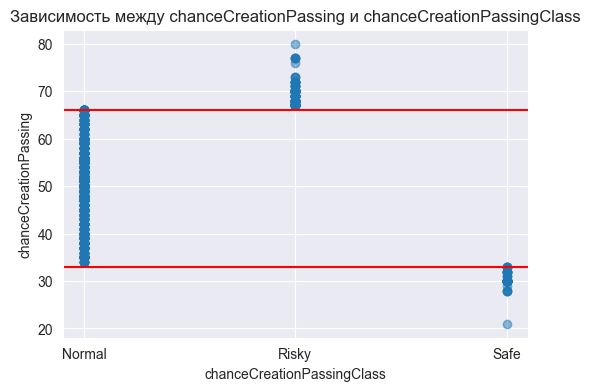

In [53]:
plt.figure(figsize=(6, 4))
plt.scatter(team_attributes['chanceCreationPassingClass'], team_attributes['chanceCreationPassing'],
            alpha=0.5)
plt.axhline(y=team_attributes[team_attributes['chanceCreationPassingClass'] == 'Safe']['chanceCreationPassing'].max()
            , color='red')
plt.axhline(y=team_attributes[team_attributes['chanceCreationPassingClass'] == 'Normal']['chanceCreationPassing'].max()
            , color='red')
plt.title('Зависимость между chanceCreationPassing и chanceCreationPassingClass')
plt.xlabel('chanceCreationPassingClass')
plt.ylabel('chanceCreationPassing')
plt.grid(True)
plt.show()

In [54]:
team_attributes.drop('chanceCreationPassingClass', axis=1, inplace=True)

кроссинг

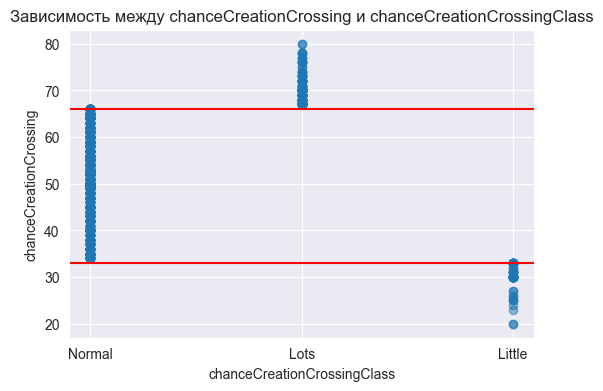

In [55]:
plt.figure(figsize=(6, 4))
plt.scatter(team_attributes['chanceCreationCrossingClass'], team_attributes['chanceCreationCrossing'],
            alpha=0.5)
plt.axhline(
    y=team_attributes[team_attributes['chanceCreationCrossingClass'] == 'Little']['chanceCreationCrossing'].max()
    , color='red')
plt.axhline(
    y=team_attributes[team_attributes['chanceCreationCrossingClass'] == 'Normal']['chanceCreationCrossing'].max()
    , color='red')
plt.title('Зависимость между chanceCreationCrossing и chanceCreationCrossingClass')
plt.xlabel('chanceCreationCrossingClass')
plt.ylabel('chanceCreationCrossing')
plt.grid(True)
plt.show()

In [56]:
team_attributes.drop('chanceCreationCrossingClass', axis=1, inplace=True)

шутинг

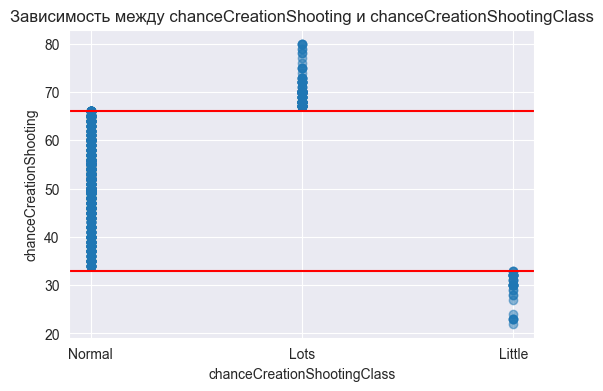

In [57]:
plt.figure(figsize=(6, 4))
plt.scatter(team_attributes['chanceCreationShootingClass'], team_attributes['chanceCreationShooting'],
            alpha=0.5)  # alpha устанавливает прозрачность точек для лучшей видимости
plt.axhline(
    y=team_attributes[team_attributes['chanceCreationShootingClass'] == 'Little']['chanceCreationShooting'].max()
    , color='red')
plt.axhline(
    y=team_attributes[team_attributes['chanceCreationShootingClass'] == 'Normal']['chanceCreationShooting'].max()
    , color='red')
plt.title('Зависимость между chanceCreationShooting и chanceCreationShootingClass')
plt.xlabel('chanceCreationShootingClass')
plt.ylabel('chanceCreationShooting')
plt.grid(True)  # Включаем сетку
plt.show()

полагаю дальше можно не продолжать и убрать все колонки с классами, для которых есть числовые значения

In [58]:
team_attributes.drop(
    ['chanceCreationShootingClass', 'defencePressureClass', 'defenceAggressionClass', 'defenceTeamWidthClass'], axis=1,
    inplace=True)

тут тоже ОНЕ ебанем

In [59]:
team_attributes['chanceCreationPositioningClass'].value_counts()

Organised    1309
Free Form     149
Name: chanceCreationPositioningClass, dtype: int64

In [60]:
team_attributes_encoded = pd.get_dummies(team_attributes['chanceCreationPositioningClass'],
                                         prefix='chanceCreationPositioning')

team_attributes = pd.concat([team_attributes, team_attributes_encoded], axis=1)

team_attributes.drop(['chanceCreationPositioningClass', 'chanceCreationPositioning_Free Form'], axis=1, inplace=True)

линия защиты

In [61]:
team_attributes['defenceDefenderLineClass'].value_counts()

Cover           1362
Offside Trap      96
Name: defenceDefenderLineClass, dtype: int64

In [62]:
team_attributes_encoded = pd.get_dummies(team_attributes['defenceDefenderLineClass'],
                                         prefix='defenceDefenderLine')

team_attributes = pd.concat([team_attributes, team_attributes_encoded], axis=1)

team_attributes.drop(['defenceDefenderLineClass', 'defenceDefenderLine_Offside Trap'], axis=1, inplace=True)

In [63]:
team_attributes

,team_name,date,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,buildUpPlayPositioning_Organised,chanceCreationPositioning_Organised,defenceDefenderLine_Cover
0,FC Aarau,2010-02-22,60,50,60,65,55,50,55,45,1,1,1
1,FC Aarau,2014-09-19,52,56,54,63,64,47,44,54,1,1,1
2,FC Aarau,2015-09-10,47,54,54,63,64,47,44,54,1,1,1
3,Aberdeen,2010-02-22,70,70,70,70,70,60,70,70,1,1,1
4,Aberdeen,2011-02-22,47,52,53,48,52,47,47,52,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,SV Zulte-Waregem,2011-02-22,52,52,52,48,53,46,48,53,1,1,1
1454,SV Zulte-Waregem,2012-02-22,54,51,47,52,50,44,55,53,1,1,1
1455,SV Zulte-Waregem,2013-09-20,54,51,47,52,32,44,58,37,1,1,1
1456,SV Zulte-Waregem,2014-09-19,54,51,47,52,32,44,58,37,1,1,1


все осталось ток с дриблингом порешать и выбрать скейлер, думаю стандарт сойдет (вроде решили)

теперь игроки


выяснилось, что не все игроки участвовавшие в матчах есть в player_attributes

In [64]:
player_attributes = pd.read_sql('SELECT * FROM Player_Attributes', conn)
player_attributes.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [65]:
players_in_realdata = []
for i in range(1, 12):
    players_in_realdata = np.unique(np.append(
        np.append(
            np.unique((match[f'home_player_{i}'])), np.unique((match[f'away_player_{i}']))),
        players_in_realdata))
np.setdiff1d(players_in_realdata, player_attributes['player_api_id'])

array([], dtype=float64)

видим, что есть один футболист которого нет почему то в player_attributes, придется дропнуть все матчи с ним

In [66]:
for i in range(1, 12):
    match = match.loc[(match[f'home_player_{i}'] != 359194.0) | (match[f'away_player_{i}'] != 359194.0)]

In [67]:
player_attributes['date'] = pd.to_datetime(player_attributes['date'])

In [68]:
player_attributes.drop(['player_fifa_api_id', 'id'], axis=1, inplace=True)

In [69]:
player_attributes.isna().sum()

player_api_id             0
date                      0
overall_rating          836
potential               836
preferred_foot          836
attacking_work_rate    3230
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision                 2713
penalties               836
marking                 836
standing_tackle         836
sliding_tackle         2713
gk_diving           

опять заменим индексы на имена

In [70]:
player = pd.read_sql('SELECT * FROM Player', conn)
player.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


In [71]:
player['birthday'] = pd.to_datetime(player['birthday'])

In [72]:
player.drop(['player_fifa_api_id', 'id'], axis=1, inplace=True)

In [73]:
player_attributes = pd.merge(player_attributes, player, left_on='player_api_id', right_on='player_api_id', how='left')

сделаем вместо даты рожденяи возраст на момент замера информации об игроке

In [74]:
player_attributes['age'] = (player_attributes['date'] - player_attributes['birthday']).astype('<m8[Y]')
player_attributes.drop('birthday', axis=1, inplace=True)

In [75]:
player_attributes.insert(0, 'age', player_attributes.pop('age'))
player_attributes.insert(0, 'weight', player_attributes.pop('weight'))
player_attributes.insert(0, 'height', player_attributes.pop('height'))
player_attributes.insert(0, 'player_name', player_attributes.pop('player_name'))

In [76]:
player_attributes

,player_name,height,weight,age,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,Aaron Appindangoye,182.88,187,23.0,505942,2016-02-18,67.0,71.0,right,medium,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,Aaron Appindangoye,182.88,187,23.0,505942,2015-11-19,67.0,71.0,right,medium,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,Aaron Appindangoye,182.88,187,23.0,505942,2015-09-21,62.0,66.0,right,medium,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,Aaron Appindangoye,182.88,187,23.0,505942,2015-03-20,61.0,65.0,right,medium,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,Aaron Appindangoye,182.88,187,14.0,505942,2007-02-22,61.0,65.0,right,medium,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183973,Zvjezdan Misimovic,180.34,176,27.0,39902,2009-08-30,83.0,85.0,right,medium,...,88.0,83.0,22.0,31.0,30.0,9.0,20.0,84.0,20.0,20.0
183974,Zvjezdan Misimovic,180.34,176,26.0,39902,2009-02-22,78.0,80.0,right,medium,...,88.0,70.0,32.0,31.0,30.0,9.0,20.0,73.0,20.0,20.0
183975,Zvjezdan Misimovic,180.34,176,26.0,39902,2008-08-30,77.0,80.0,right,medium,...,88.0,70.0,32.0,31.0,30.0,9.0,20.0,73.0,20.0,20.0
183976,Zvjezdan Misimovic,180.34,176,25.0,39902,2007-08-30,78.0,81.0,right,medium,...,88.0,53.0,28.0,32.0,30.0,9.0,20.0,73.0,20.0,20.0


видим, что после 08го года пропущенных значений много меньше, так что далее просто ограничим наше исследование сезонами с 08/09 по 15/16

In [77]:
player_attributes.loc[player_attributes['date'] > '2008-07-01'].isna().sum()

player_name               0
height                    0
weight                    0
age                       0
player_api_id             0
date                      0
overall_rating          100
potential               100
preferred_foot          100
attacking_work_rate    1596
defensive_work_rate     100
crossing                100
finishing               100
heading_accuracy        100
short_passing           100
volleys                1159
dribbling               100
curve                  1159
free_kick_accuracy      100
long_passing            100
ball_control            100
acceleration            100
sprint_speed            100
agility                1159
reactions               100
balance                1159
shot_power              100
jumping                1159
stamina                 100
strength                100
long_shots              100
aggression              100
interceptions           100
positioning             100
vision                 1159
penalties           

In [78]:
player_attributes = player_attributes.loc[player_attributes['date'] > '2008-07-01'].copy()
match = match.loc[match['date'] > '2009-07-01'].copy()

как будто potential можно дропнуть

In [79]:
player_attributes.drop('potential', axis=1, inplace=True)

делаем OHE для ноги

In [80]:
player_attributes['preferred_foot'].value_counts()

right    126276
left      41055
Name: preferred_foot, dtype: int64

In [81]:
player_attributes_encoded = pd.get_dummies(player_attributes['preferred_foot'],
                                           prefix='preferred_foot')

player_attributes = pd.concat([player_attributes, player_attributes_encoded], axis=1)

player_attributes.drop(['preferred_foot', 'preferred_foot_left'], axis=1, inplace=True)

смотрим на attacking_work_rate

In [82]:
player_attributes['attacking_work_rate'].value_counts()

medium    114352
high       40331
low         7828
None        2884
norm         234
y             74
le            69
stoc          63
Name: attacking_work_rate, dtype: int64

Тут нужно кодиком АНдрюхи показать, что для адекватных значений эта штука полностью коррелирует с обычным атакрейтом и дропнуть , с дефенсрейтом тожсамое

In [83]:
player_attributes['pace'] = 0.55 * player_attributes['sprint_speed'] + 0.45 * player_attributes['acceleration']
player_attributes['shooting'] = 0.45 * player_attributes['finishing'] + 0.2 * player_attributes['long_shots'] + 0.2 * \
                                player_attributes['shot_power'] + 0.05 * player_attributes[
                                    'positioning'] + 0.05 * player_attributes['penalties'] + 0.05 * player_attributes[
                                    'volleys']
player_attributes['passing'] = 0.35 * player_attributes['short_passing'] + 0.2 * player_attributes['vision'] + 0.2 * \
                               player_attributes['crossing'] + 0.15 * player_attributes[
                                   'long_passing'] + 0.05 * player_attributes['curve'] + 0.05 * player_attributes[
                                   'free_kick_accuracy']
player_attributes['dribbling'] = 0.5 * player_attributes['dribbling'] + 0.35 * player_attributes['ball_control'] + 0.1 * \
                                 player_attributes['agility'] + 0.05 * player_attributes['balance']
player_attributes['defending'] = 0.3 * player_attributes['marking'] + 0.3 * player_attributes['standing_tackle'] + 0.2 * \
                                 player_attributes['interceptions'] + 0.1 * player_attributes[
                                     'heading_accuracy'] + 0.1 * player_attributes['sliding_tackle']
player_attributes['physical'] = 0.5 * player_attributes['strength'] + 0.25 * player_attributes['stamina'] + 0.25 * \
                                player_attributes['aggression'] + 0.05 * player_attributes['jumping']

In [84]:
# player_attributes.drop('attacking_work_rate', axis=1, inplace=True)

тож самое с defensive_work_rate, только тут как будто бы есть какие то данные выбивающиеся из основной массы, но нам их трудно интерпретирвоать и они находятся в подавляющем меньшинстве (еть варик сделать 0-3 -low, 4-7 - medium и тд, зодумайтесь)

в конце концов дропнул

In [85]:
# player_attributes.drop('defensive_work_rate', axis=1, inplace=True)

In [86]:
player_attributes

,player_name,height,weight,age,player_api_id,date,overall_rating,attacking_work_rate,defensive_work_rate,crossing,...,gk_handling,gk_kicking,gk_positioning,gk_reflexes,preferred_foot_right,pace,shooting,passing,defending,physical
0,Aaron Appindangoye,182.88,187,23.0,505942,2016-02-18,67.0,medium,medium,49.0,...,11.0,10.0,8.0,8.0,1,62.20,44.65,55.75,68.2,72.15
1,Aaron Appindangoye,182.88,187,23.0,505942,2015-11-19,67.0,medium,medium,49.0,...,11.0,10.0,8.0,8.0,1,62.20,44.65,55.75,68.2,72.15
2,Aaron Appindangoye,182.88,187,23.0,505942,2015-09-21,62.0,medium,medium,49.0,...,11.0,10.0,8.0,8.0,1,62.20,44.65,55.75,61.5,70.15
3,Aaron Appindangoye,182.88,187,23.0,505942,2015-03-20,61.0,medium,medium,48.0,...,10.0,9.0,7.0,7.0,1,62.20,43.65,54.75,59.1,69.90
5,Aaron Cresswell,170.18,146,26.0,155782,2016-04-21,74.0,high,medium,80.0,...,7.0,9.0,9.0,12.0,0,78.45,58.40,71.20,72.3,69.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183971,Zvjezdan Misimovic,180.34,176,28.0,39902,2011-02-22,81.0,medium,low,81.0,...,13.0,8.0,15.0,5.0,1,67.20,79.00,83.95,31.2,69.65
183972,Zvjezdan Misimovic,180.34,176,28.0,39902,2010-08-30,83.0,medium,low,84.0,...,13.0,8.0,15.0,5.0,1,67.20,79.00,85.65,31.2,69.65
183973,Zvjezdan Misimovic,180.34,176,27.0,39902,2009-08-30,83.0,medium,low,84.0,...,20.0,84.0,20.0,20.0,1,69.30,78.35,86.35,40.4,68.40
183974,Zvjezdan Misimovic,180.34,176,26.0,39902,2009-02-22,78.0,medium,low,74.0,...,20.0,73.0,20.0,20.0,1,66.55,74.75,80.75,40.0,67.15


больше катгориальных нет, остается только кодиком андрюхи все это к божескому виду привести и объеденить все колонки, Эндрю, на тебе задача объяснить что эти формулы релевантны и имеют смысол

теперь сделаем фреймы с атрибутами вратарей и полевых

In [87]:
gk_attributes = player_attributes[player_attributes['player_api_id'].isin(goalkeepers)].copy()

In [88]:
fl_attributes = player_attributes[player_attributes['player_api_id'].isin(fielders)].copy()

In [89]:
fl_attributes

,player_name,height,weight,age,player_api_id,date,overall_rating,attacking_work_rate,defensive_work_rate,crossing,...,gk_handling,gk_kicking,gk_positioning,gk_reflexes,preferred_foot_right,pace,shooting,passing,defending,physical
0,Aaron Appindangoye,182.88,187,23.0,505942,2016-02-18,67.0,medium,medium,49.0,...,11.0,10.0,8.0,8.0,1,62.20,44.65,55.75,68.2,72.15
1,Aaron Appindangoye,182.88,187,23.0,505942,2015-11-19,67.0,medium,medium,49.0,...,11.0,10.0,8.0,8.0,1,62.20,44.65,55.75,68.2,72.15
2,Aaron Appindangoye,182.88,187,23.0,505942,2015-09-21,62.0,medium,medium,49.0,...,11.0,10.0,8.0,8.0,1,62.20,44.65,55.75,61.5,70.15
3,Aaron Appindangoye,182.88,187,23.0,505942,2015-03-20,61.0,medium,medium,48.0,...,10.0,9.0,7.0,7.0,1,62.20,43.65,54.75,59.1,69.90
5,Aaron Cresswell,170.18,146,26.0,155782,2016-04-21,74.0,high,medium,80.0,...,7.0,9.0,9.0,12.0,0,78.45,58.40,71.20,72.3,69.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183971,Zvjezdan Misimovic,180.34,176,28.0,39902,2011-02-22,81.0,medium,low,81.0,...,13.0,8.0,15.0,5.0,1,67.20,79.00,83.95,31.2,69.65
183972,Zvjezdan Misimovic,180.34,176,28.0,39902,2010-08-30,83.0,medium,low,84.0,...,13.0,8.0,15.0,5.0,1,67.20,79.00,85.65,31.2,69.65
183973,Zvjezdan Misimovic,180.34,176,27.0,39902,2009-08-30,83.0,medium,low,84.0,...,20.0,84.0,20.0,20.0,1,69.30,78.35,86.35,40.4,68.40
183974,Zvjezdan Misimovic,180.34,176,26.0,39902,2009-02-22,78.0,medium,low,74.0,...,20.0,73.0,20.0,20.0,1,66.55,74.75,80.75,40.0,67.15


In [90]:
gk_attributes

,player_name,height,weight,age,player_api_id,date,overall_rating,attacking_work_rate,defensive_work_rate,crossing,...,gk_handling,gk_kicking,gk_positioning,gk_reflexes,preferred_foot_right,pace,shooting,passing,defending,physical
172,Aaron Lennox,190.50,181,23.0,528212,2016-02-25,48.0,medium,medium,12.0,...,41.0,39.0,51.0,53.0,1,21.05,17.80,17.75,15.6,33.65
173,Aaron Lennox,190.50,181,22.0,528212,2016-01-28,48.0,medium,medium,12.0,...,41.0,39.0,51.0,53.0,1,21.05,17.80,17.75,15.6,33.65
174,Aaron Lennox,190.50,181,21.0,528212,2014-12-27,48.0,medium,medium,12.0,...,41.0,39.0,51.0,53.0,1,21.05,17.80,17.75,15.6,33.65
175,Aaron Lennox,190.50,181,21.0,528212,2014-10-31,48.0,medium,medium,12.0,...,41.0,39.0,51.0,53.0,1,21.05,17.80,17.75,15.6,33.65
176,Aaron Lennox,190.50,181,21.0,528212,2014-10-10,48.0,medium,medium,12.0,...,41.0,39.0,51.0,53.0,1,21.05,17.80,17.75,15.6,33.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183531,Zeljko Brkic,198.12,209,26.0,157284,2013-02-15,78.0,medium,medium,12.0,...,74.0,55.0,82.0,80.0,1,54.45,18.10,26.55,15.4,63.65
183532,Zeljko Brkic,198.12,209,26.0,157284,2012-08-31,76.0,medium,medium,12.0,...,76.0,51.0,78.0,78.0,1,54.45,18.10,26.55,15.4,63.65
183533,Zeljko Brkic,198.12,209,25.0,157284,2011-08-30,71.0,medium,medium,12.0,...,72.0,73.0,64.0,78.0,1,59.40,20.25,27.00,12.7,70.75
183535,Zeljko Kalac,203.20,209,36.0,30850,2009-02-22,73.0,None,o,20.0,...,73.0,71.0,73.0,75.0,1,44.30,NaN,NaN,NaN,NaN


как то надо придумать какие параметры важны для голкиперов, очевидно не только те чт с пометкой gk

In [91]:
columns_gk = ['player_name', 'height', 'weight', 'age', 'player_api_id', 'date', 'overall_rating', 'sprint_speed',
              'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']
gk_attributes.drop(gk_attributes.columns.difference(columns_gk), axis=1, inplace=True)

In [92]:
columns_fl = ['player_name', 'height', 'weight', 'age', 'player_api_id', 'date', 'overall_rating', 'pace',
              'shooting', 'passing', 'dribbling', 'defending', 'physical', 'preferred_foot_right']
fl_attributes.drop(fl_attributes.columns.difference(columns_fl), axis=1, inplace=True)

In [93]:
fl_attributes

,player_name,height,weight,age,player_api_id,date,overall_rating,dribbling,preferred_foot_right,pace,shooting,passing,defending,physical
0,Aaron Appindangoye,182.88,187,23.0,505942,2016-02-18,67.0,51.80,1,62.20,44.65,55.75,68.2,72.15
1,Aaron Appindangoye,182.88,187,23.0,505942,2015-11-19,67.0,51.80,1,62.20,44.65,55.75,68.2,72.15
2,Aaron Appindangoye,182.88,187,23.0,505942,2015-09-21,62.0,51.80,1,62.20,44.65,55.75,61.5,70.15
3,Aaron Appindangoye,182.88,187,23.0,505942,2015-03-20,61.0,50.95,1,62.20,43.65,54.75,59.1,69.90
5,Aaron Cresswell,170.18,146,26.0,155782,2016-04-21,74.0,73.65,0,78.45,58.40,71.20,72.3,69.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183971,Zvjezdan Misimovic,180.34,176,28.0,39902,2011-02-22,81.0,80.75,1,67.20,79.00,83.95,31.2,69.65
183972,Zvjezdan Misimovic,180.34,176,28.0,39902,2010-08-30,83.0,83.10,1,67.20,79.00,85.65,31.2,69.65
183973,Zvjezdan Misimovic,180.34,176,27.0,39902,2009-08-30,83.0,83.10,1,69.30,78.35,86.35,40.4,68.40
183974,Zvjezdan Misimovic,180.34,176,26.0,39902,2009-02-22,78.0,83.95,1,66.55,74.75,80.75,40.0,67.15


думаю будем делать все как тут https://fifarus.ru/fifa-17/kak-schitaetsya-itogovyj-rejting-igrokov-v-fifa

так остается придумать как вставить релевантные для каждого матча данные об игроке и решить описанные выше задачи, и у нас будет полностью готовый фрейм на котором можно проверять ВАШИ гиппотезы и сувать в модельки

Тут дальше я буду реализовывать мерж фрейма с игроками и матчами, несмотря на наны и прочую хуйню

In [94]:
match

,league_name,away_team_name,home_team_name,season,stage,date,match_api_id,home_team_goal,away_team_goal,home_player_1,...,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11
19,Belgium Jupiler League,KAA Gent,KSV Cercle Brugge,2009/2010,1,2009-08-02,665321,1,3,36835.0,...,38337.0,38255.0,12473.0,41109.0,33662.0,37044.0,26916.0,37065.0,12574.0,46335.0
20,Belgium Jupiler League,SV Zulte-Waregem,Sporting Lokeren,2009/2010,1,2009-08-01,665322,1,1,30934.0,...,37100.0,37903.0,37889.0,94030.0,37902.0,37886.0,37981.0,131531.0,75500.0,130027.0
21,Belgium Jupiler League,RSC Anderlecht,KV Kortrijk,2009/2010,1,2009-08-01,665323,0,2,37971.0,...,33620.0,38388.0,13423.0,38389.0,38378.0,38383.0,38393.0,38253.0,37069.0,46552.0
22,Belgium Jupiler League,RSC Anderlecht,Club Brugge KV,2009/2010,10,2009-10-04,665411,4,2,37990.0,...,33620.0,38388.0,38389.0,38253.0,38378.0,38383.0,38393.0,106013.0,37069.0,12692.0
23,Belgium Jupiler League,Sporting Lokeren,KV Mechelen,2009/2010,10,2009-10-03,665417,2,0,39573.0,...,38292.0,39594.0,25465.0,38273.0,38945.0,38290.0,95609.0,15662.0,34334.0,69629.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21369,Switzerland Super League,FC Thun,FC Zürich,2015/2016,8,2015-09-13,1992089,3,3,274776.0,...,8800.0,320183.0,67304.0,67389.0,133126.0,186524.0,93223.0,121115.0,25809.0,289732.0
21370,Switzerland Super League,FC Thun,FC St. Gallen,2015/2016,9,2015-09-22,1992091,1,0,42231.0,...,563066.0,8800.0,67304.0,158253.0,133126.0,186524.0,93223.0,121115.0,232110.0,289732.0
21371,Switzerland Super League,FC Luzern,FC Vaduz,2015/2016,9,2015-09-23,1992092,1,2,33272.0,...,114792.0,150007.0,178119.0,27232.0,570830.0,260708.0,201704.0,36382.0,34082.0,95257.0
21372,Switzerland Super League,FC Sion,Grasshopper Club Zürich,2015/2016,9,2015-09-23,1992093,2,0,157856.0,...,67349.0,202663.0,32597.0,114794.0,188114.0,25840.0,482200.0,95230.0,451335.0,275122.0


функции находят сверху и снизу ближайшие даты для игрока в фрейме с атрибутами

In [95]:
def prev_dates_to_match_gk(row, column):
    prev_dates = list(filter(lambda y: y <= row['date'],
                             gk_attributes[gk_attributes['player_api_id'] == row[column]]['date']))
    if prev_dates:
        return np.max(prev_dates)
    return last_date


def next_dates_to_match_gk(row, column):
    next_dates = list(filter(lambda y: y >= row['date'],
                             gk_attributes[gk_attributes['player_api_id'] == row[column]]['date']))
    if next_dates:
        return np.min(next_dates)
    return last_date


def prev_dates_to_match_fl(row, column):
    prev_dates = list(filter(lambda y: y <= row['date'],
                             fl_attributes[fl_attributes['player_api_id'] == row[column]]['date']))
    if prev_dates:
        return np.max(prev_dates)
    return last_date


def next_dates_to_match_fl(row, column):
    next_dates = list(filter(lambda y: y >= row['date'],
                             fl_attributes[fl_attributes['player_api_id'] == row[column]]['date']))
    if next_dates:
        return np.min(next_dates)
    return last_date

здесь меняем player_api_id на соответсвующий индекс из фрейма с атрибутами релевантный для данного матча по времени, чтобы потом все это смерджить

In [98]:
def neares_player_index(row):
    for column in columns_players:
        cur_player = row[column]
        # print(row['date'], row['match_api_id'], column)
        if cur_player in goalkeepers:
            row[column] = gk_attributes.loc[(gk_attributes['date'] == np.min([next_dates_to_match_gk(row, column)] +
                                                                             [prev_dates_to_match_gk(row, column)])) &
                                            (gk_attributes['player_api_id'] == cur_player)].index[0]
        else:
            row[column] = fl_attributes.loc[(fl_attributes['date'] == np.min([next_dates_to_match_fl(row, column)] +
                                                                             [prev_dates_to_match_fl(row, column)])) &
                                            (fl_attributes['player_api_id'] == cur_player)].index[0]
    return row

In [ ]:
last_date = np.max(match['date'])
columns_players = [f'home_player_{i}' for i in range(1, 12)] + [f'away_player_{i}' for i in range(1, 12)]
match_full = match.copy()

match_full = match_full.apply(neares_player_index, axis=1)

In [ ]:
match_full

In [ ]:
match.loc[match['match_api_id'] == 1778036]

In [ ]:
gk_attributes[gk_attributes['player_api_id'] == 359194.0]

In [ ]:
fl_attributes[fl_attributes['player_api_id'] == 359194.0]

In [ ]:
player_attributes[player_attributes['player_name'] == 'Quini']

In [ ]:
player[player['player_name'] == 'Quini']

In [ ]:
match_full

In [ ]:
# match_full[match_full['date'] > '2014-07-01']

In [ ]:
player_attributes[player_attributes['player_api_id'] == 37047]

In [ ]:
match[match['date'] > '2014-07-01']